In [ ]:
import pandas as pd
import numpy as np
import spacy
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm
import matplotlib.pyplot as plt
from importnb import Notebook
from captum.attr import IntegratedGradients, Lime
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from matplotlib import cm, colors

# xAI

In [ ]:
device = torch.device("cpu")  # Captum doesn't support MPS
print("Using device:", device)

# Load tokenized climate data
CLIMATE_TOKENISED_BERT_DIR = './cache/climate_tokenised_bert.pkl'
with open(CLIMATE_TOKENISED_BERT_DIR, 'rb') as f:
    climate_tokenised_bert = pickle.load(f)

subset_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
climate_tokenised_bert_subset = {
    "input_ids": climate_tokenised_bert["input_ids"][subset_indices],
    "token_type_ids": climate_tokenised_bert["token_type_ids"][subset_indices],
    "attention_mask": climate_tokenised_bert["attention_mask"][subset_indices]
}

# Load model and tokenizer
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()
print("Model and tokenizer loaded successfully from:", model_path)

# Prepare data tensors and embeddings
input_ids = torch.clone(climate_tokenised_bert_subset["input_ids"]).detach().to(dtype=torch.long, device=device)
attention_mask = torch.clone(climate_tokenised_bert_subset["attention_mask"]).detach().to(dtype=torch.float32, device=device)
# Extract embeddings directly from input_ids
embedding_layer = bert_uncased_finetuned.get_input_embeddings()
embeddings = embedding_layer(input_ids).clone().detach().requires_grad_(True).to(device)
# Derive tokens from input_ids for reconstruction
tokens_list = [bert_tokenizer.convert_ids_to_tokens(ids.cpu().numpy()) for ids in input_ids]


# === Helper Functions === #

# Reconstruct sentence and attributions
def reconstruct_sentence(tokens, attributions, tokenizer):
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token, score in zip(tokens, attributions):
        if token.startswith("##"):
            current_score += score
        else:
            if current_word:  # Save previous word
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            current_word, current_score = token, score

    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    special_tokens = tokenizer.special_tokens_map.values()
    filtered_tokens = [t for t in word_tokens if t not in special_tokens]
    filtered_attributions = [
        a for t, a in zip(word_tokens, word_attributions) if t not in special_tokens
    ]
    sentence = " ".join(filtered_tokens)
    return sentence, filtered_attributions

# Visualize token attributions
def visualize_token_attributions(tokens, attributions, cmap='bwr', title=None):
    attributions = np.array(attributions)
    assert len(tokens) == len(attributions), "Tokens and attributions lengths do not match!"
    norm = colors.Normalize(vmin=attributions.min(), vmax=attributions.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    html_content = f"<div style='line-height:1.6;'>"
    for token, score in zip(tokens, attributions):
        color = colors.rgb2hex(scalar_map.to_rgba(score))
        html_content += f"<span style='background-color:{color}; padding:2px; margin:2px;'>{token}</span> "
    html_content += "</div>"
    display(HTML(html_content))

# Compute Integrated Gradients
def compute_integrated_gradients(embeddings, attention_mask, sample_input_ids, tokenizer, target_class=0, steps=50):
    def forward_func(embeddings, attention_mask=None):
        outputs = bert_uncased_finetuned(inputs_embeds=embeddings, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=target_class,
        n_steps=steps,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_ig.sum(dim=-1)[0].detach().cpu().numpy()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)


def compute_lime(sample_input_ids, attention_mask, tokenizer, target_class=0, n_samples=100):
    def forward_func(input_ids, attention_mask=None):
        outputs = bert_uncased_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    lime = Lime(forward_func)
    attributions_lime = lime.attribute(
        inputs=sample_input_ids,
        n_samples=n_samples,
        additional_forward_args=(attention_mask,),
        target=target_class,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_lime[0].detach().cpu().numpy().flatten()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)

# === Main Execution Loop === #
for idx in range(len(climate_tokenised_bert_subset["input_ids"])):
    print(f"\n--- Sample {idx + 1} ---")
    
    # Prepare single-sample embeddings, attention mask, and input_ids
    sample_embeddings = embeddings[idx].unsqueeze(0)
    sample_attention_mask = attention_mask[idx].unsqueeze(0)
    sample_input_ids = input_ids[idx].unsqueeze(0)
    
    # IG
    sentence_ig, word_attributions_ig = compute_integrated_gradients(
        embeddings=sample_embeddings,
        attention_mask=sample_attention_mask,
        sample_input_ids=sample_input_ids,
        tokenizer=bert_tokenizer,
        target_class=0,
        steps=50
    )
    print(f"Reconstructed Sentence: {sentence_ig}")
    visualize_token_attributions(sentence_ig.split(), word_attributions_ig, cmap='bwr', title="IG Attributions")
    print(f"Word-Level Attributions (IG): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_ig.split(), word_attributions_ig)])}")

    # LIME
    sentence_lime, word_attributions_lime = compute_lime(
        sample_input_ids=sample_input_ids,
        attention_mask=sample_attention_mask,
        tokenizer=bert_tokenizer,
        target_class=0,
        n_samples=100
    )
    visualize_token_attributions(sentence_lime.split(), word_attributions_lime, cmap='coolwarm', title="LIME Attributions")
    print(f"Word-Level Attributions (LIME): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_lime.split(), word_attributions_lime)])}")


Using device: cpu
Model and tokenizer loaded successfully from: ./models/transformer_results

--- Sample 1 ---
Reconstructed Sentence: any comparison of efficiency between solar and fossil fuels is non at best and intentionally misleading at worst . in no universe is light - & gt ; photo cell - & gt ; electricity less efficient than light - & gt ; entire food chain - & gt ; biomass - & gt ; decomposition - & gt ; millions of years of geo heat and pressure - & gt ; extraction - & gt ; refining and transport - & gt ; burning - & gt ; turbine generator - & gt ; electricity . ugly ? more ugly than power lines , roads , apartment buildings , tractors , fences , etc etc etc ? you ' re simply not used to it . also , who cares ? sure , millions of people died in the displacement from sea rise , famine cause by climate change , and wars from resource scar , but thank god we didn ' t have to look at those solar panels occasionally . offshore fra ? fuck sake . have you already forgotten the deep 

Word-Level Attributions (IG): any (0.0000), comparison (-0.0001), of (0.0001), efficiency (0.0000), between (0.0002), solar (-0.0002), and (0.0000), fossil (-0.0000), fuels (-0.0001), is (-0.0000), non (-0.0001), at (0.0001), best (0.0000), and (0.0000), intentionally (-0.0001), misleading (-0.0001), at (0.0000), worst (-0.0000), . (0.0001), in (0.0001), no (-0.0000), universe (-0.0001), is (-0.0000), light (-0.0001), - (0.0000), & (-0.0000), gt (-0.0000), ; (0.0000), photo (-0.0001), cell (-0.0000), - (0.0000), & (-0.0000), gt (-0.0000), ; (0.0000), electricity (-0.0001), less (-0.0000), efficient (-0.0000), than (0.0000), light (-0.0001), - (0.0000), & (-0.0000), gt (-0.0000), ; (0.0000), entire (-0.0000), food (-0.0000), chain (-0.0000), - (0.0000), & (-0.0000), gt (-0.0001), ; (0.0001), biomass (-0.0001), - (0.0000), & (-0.0000), gt (-0.0000), ; (0.0001), decomposition (-0.0000), - (0.0000), & (-0.0000), gt (-0.0001), ; (0.0000), millions (-0.0000), of (0.0000), years (-0.0000), of

Word-Level Attributions (LIME): any (0.0000), comparison (0.0000), of (0.0000), efficiency (0.0000), between (0.0000), solar (0.0000), and (0.0000), fossil (0.0000), fuels (0.0000), is (0.0000), non (0.0000), at (0.0000), best (0.0000), and (0.0000), intentionally (0.0000), misleading (0.0000), at (0.0000), worst (0.0000), . (0.0000), in (0.0037), no (0.0000), universe (0.0000), is (0.0000), light (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), photo (0.0000), cell (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), electricity (0.0000), less (0.0000), efficient (0.0000), than (0.0000), light (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), entire (0.0000), food (0.0000), chain (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), biomass (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), decomposition (0.0000), - (0.0000), & (0.0000), gt (0.0000), ; (0.0000), millions (0.0000), of (0.0000), years (0.0000), of (0.0000), geo (0.0000), heat (0.000

Word-Level Attributions (IG): i (0.1518), ' (0.3657), m (-0.0013), honestly (0.0379), waiting (-0.0074), for (0.0077), climate (-0.0418), change (-0.0065), and (0.0098), the (-0.0036), impacts (-0.0519), of (0.0036), that (0.0073), to (-0.0124), kick (-0.0276), some (-0.0061), fucking (-0.0357), sense (-0.0021), into (-0.0234), people (-0.0308), . (0.0949), but (-0.0036), who (0.0089), am (0.0225), i (-0.0150), kidding (-0.0137), it (-0.0214), still (-0.0039), just (-0.0008), be (-0.0001), more (-0.0078), of (0.0027), the (-0.0025), poor (-0.0085), suffering (-0.0080), while (0.0063), the (-0.0011), rich (0.0003), claim (-0.0063), victim (-0.0109), hood (-0.0758), for (0.0004), hand (-0.0197), while (0.0045), letting (-0.0118), us (-0.0392), all (0.0008), star (-0.0080), . (0.1154), its (-0.0142), honestly (-0.0159), hard (-0.0071), some (-0.0036), days (-0.0073), to (-0.0034), not (-0.0052), just (-0.0045), give (-0.0055), up (-0.0044), , (0.0269), and (0.0030), i (-0.0079), truly (-0

Word-Level Attributions (LIME): i (-0.0061), ' (0.8609), m (0.0000), honestly (0.0000), waiting (0.0000), for (0.0000), climate (0.0000), change (0.0000), and (0.0000), the (0.0000), impacts (0.0000), of (0.0000), that (0.0000), to (0.0000), kick (0.0000), some (0.0000), fucking (0.0000), sense (0.0000), into (0.0000), people (0.0000), . (0.0000), but (0.0000), who (0.0000), am (0.0000), i (0.0000), kidding (0.0000), it (0.0000), still (0.0000), just (0.0000), be (0.0000), more (0.0000), of (0.0000), the (0.0000), poor (0.0000), suffering (0.0000), while (0.0000), the (0.0000), rich (0.0000), claim (0.0000), victim (0.0000), hood (0.0000), for (0.0000), hand (0.0000), while (0.0000), letting (0.0000), us (0.0000), all (0.0000), star (0.0000), . (0.0000), its (0.0000), honestly (0.0000), hard (0.0000), some (0.0000), days (0.0000), to (0.0000), not (0.0000), just (0.0000), give (0.0000), up (0.0000), , (0.0000), and (0.0000), i (0.0000), truly (0.0000), wonder (0.0000), if (0.0000), and

Word-Level Attributions (IG): not (-0.0012), just (-0.0017), sacramento (-0.0167), . (0.0022), it (-0.0019), ' (0.0151), s (-0.0021), actually (0.0004), happening (-0.0015), all (0.0002), over (-0.0004), the (-0.0005), world (-0.0003), . (0.0039), climate (-0.0018), change (-0.0000), is (0.0009), real (0.0001), , (0.0009), believe (0.0009), it (-0.0012), or (0.0006), not (-0.0016), . (0.0047)


Word-Level Attributions (LIME): not (0.0000), just (0.0000), sacramento (0.0000), . (0.0000), it (0.0000), ' (0.1860), s (0.0147), actually (-0.0035), happening (0.0000), all (0.0000), over (0.0000), the (0.0000), world (-0.0408), . (0.0000), climate (0.0000), change (0.0000), is (0.0000), real (0.0000), , (0.0000), believe (-0.0364), it (0.0000), or (0.0000), not (0.0000), . (0.0000)

--- Sample 4 ---
Reconstructed Sentence: i think climate change tends to get some people ri up . when i was part of a debate club , they loved throwing that subject in . one case we had to discuss was whether or not it was okay to fly if it poll the air . a friend of mine on the team got very worked up because he loves to travel . at the end , we actually had to make up because our disagreement about flying got very heated .


Word-Level Attributions (IG): i (-0.0008), think (-0.0001), climate (-0.0005), change (-0.0002), tends (0.0003), to (-0.0000), get (-0.0001), some (-0.0001), people (-0.0002), ri (-0.0002), up (0.0000), . (0.0005), when (0.0001), i (-0.0009), was (0.0001), part (-0.0000), of (0.0002), a (-0.0000), debate (-0.0001), club (-0.0000), , (0.0002), they (-0.0001), loved (0.0000), throwing (-0.0000), that (0.0001), subject (0.0000), in (0.0002), . (0.0005), one (0.0000), case (-0.0000), we (-0.0008), had (0.0001), to (0.0001), discuss (0.0000), was (0.0001), whether (0.0000), or (0.0001), not (-0.0000), it (-0.0001), was (0.0001), okay (-0.0002), to (0.0001), fly (-0.0000), if (-0.0000), it (-0.0001), poll (-0.0002), the (-0.0000), air (0.0000), . (0.0004), a (0.0000), friend (0.0001), of (0.0002), mine (-0.0002), on (0.0001), the (-0.0000), team (-0.0001), got (-0.0000), very (-0.0000), worked (-0.0000), up (0.0000), because (0.0001), he (-0.0000), loves (0.0000), to (0.0000), travel (-0.000

Word-Level Attributions (LIME): i (-0.0824), think (0.0000), climate (0.0000), change (0.0000), tends (0.0000), to (0.0000), get (0.0000), some (0.0000), people (0.0000), ri (0.0036), up (0.0000), . (0.0000), when (0.0000), i (-0.0649), was (0.0000), part (0.0000), of (0.0000), a (0.0000), debate (0.0000), club (0.0000), , (0.0000), they (0.0000), loved (0.0000), throwing (0.0000), that (0.0000), subject (0.0000), in (0.0000), . (0.0000), one (0.0000), case (0.0000), we (-0.0492), had (0.0000), to (0.0000), discuss (0.0000), was (0.0113), whether (0.0000), or (0.0000), not (0.0000), it (0.0000), was (0.0000), okay (-0.0341), to (0.0000), fly (0.0000), if (0.0000), it (0.0000), poll (0.0000), the (0.0000), air (-0.0067), . (0.0000), a (0.0000), friend (0.0000), of (0.0000), mine (0.0000), on (0.0000), the (-0.0026), team (0.0000), got (0.0000), very (0.0000), worked (0.0000), up (0.0000), because (0.0000), he (0.0000), loves (0.0000), to (0.0000), travel (0.0000), . (0.0000), at (0.0000

Word-Level Attributions (IG): na (-0.0046), how (-0.0021), could (-0.0010), anyone (0.0004), be (-0.0002), mad (0.0002), at (-0.0014), a (-0.0010), face (-0.0005), like (0.0009), that (0.0004), . (0.0023), . (0.0024), . (0.0025), must (0.0012), definitely (-0.0002), be (0.0005), climate (-0.0011), change (0.0003)


Word-Level Attributions (LIME): na (-0.0228), how (-0.1375), could (0.0089), anyone (-0.0202), be (0.0000), mad (0.0000), at (0.0000), a (0.0000), face (0.0000), like (0.0000), that (0.0000), . (0.0000), . (0.0006), . (0.0000), must (0.0000), definitely (-0.0186), be (0.0000), climate (0.0000), change (0.0000)

--- Sample 6 ---
Reconstructed Sentence: can i suggest maybe hon in on lgbt ? it ' s a useful grab - bag for talking about issues like law reform and workplace discrimination , but less so as you dive into addressing people ' s stated needs . literally 95 % of my congregation voted for marriage equality a couple of years ago , and we were active in the push for the ordination of people in same gender relationships . meanwhile there ' s been significant push on the church council ' s idea to include our preferred pronouns in our written communications as a matter of course , so i ' ll be spending this afternoon trying to begin a pathway to a respectful conversation between those 

Word-Level Attributions (IG): can (0.0009), i (-0.0002), suggest (-0.0000), maybe (-0.0006), hon (-0.0001), in (0.0002), on (-0.0006), lgbt (-0.0021), ? (0.0007), it (-0.0004), ' (0.0035), s (-0.0000), a (-0.0007), useful (-0.0001), grab (-0.0014), - (0.0015), bag (-0.0005), for (0.0002), talking (-0.0002), about (0.0000), issues (-0.0002), like (0.0001), law (0.0000), reform (-0.0002), and (0.0003), workplace (-0.0003), discrimination (-0.0006), , (0.0008), but (-0.0001), less (-0.0002), so (0.0000), as (0.0002), you (-0.0013), dive (-0.0001), into (-0.0001), addressing (-0.0002), people (-0.0006), ' (0.0038), s (-0.0001), stated (-0.0003), needs (-0.0000), . (0.0013), literally (-0.0004), 95 (-0.0001), % (-0.0003), of (0.0001), my (-0.0009), congregation (-0.0002), voted (-0.0005), for (0.0001), marriage (-0.0001), equality (-0.0007), a (-0.0002), couple (-0.0001), of (0.0001), years (-0.0001), ago (-0.0001), , (0.0006), and (0.0001), we (-0.0014), were (0.0001), active (-0.0001), in

Word-Level Attributions (LIME): can (0.0000), i (0.0000), suggest (0.0037), maybe (-0.0145), hon (0.0000), in (0.0000), on (0.0000), lgbt (-0.0055), ? (0.0000), it (0.0000), ' (0.0944), s (0.0000), a (0.0000), useful (0.0361), grab (0.0000), - (-0.0566), bag (0.0000), for (0.0015), talking (0.0140), about (0.0000), issues (0.0000), like (0.0000), law (0.0200), reform (0.0000), and (0.0000), workplace (0.0000), discrimination (-0.0273), , (0.0046), but (0.0000), less (0.0000), so (0.0000), as (0.0000), you (-0.0437), dive (0.0000), into (0.0000), addressing (0.0000), people (0.0000), ' (0.0194), s (0.0000), stated (0.0000), needs (0.0000), . (0.0166), literally (0.0000), 95 (0.0000), % (0.0000), of (0.0000), my (0.0000), congregation (0.0000), voted (0.0316), for (0.0000), marriage (0.0000), equality (0.0000), a (0.0000), couple (0.0000), of (0.0000), years (0.0000), ago (0.0000), , (0.0000), and (0.0000), we (0.0000), were (0.0000), active (0.0000), in (0.0000), the (0.0000), push (0.0

Word-Level Attributions (IG): they (-0.0003), need (-0.0004), to (-0.0004), change (0.0001), laws (0.0005), so (0.0005), it (-0.0004), ' (0.0045), s (-0.0005), more (-0.0003), worth (0.0005), selling (0.0000), agriculture (-0.0027), products (0.0000), in (0.0004), the (0.0001), us (-0.0020), rather (-0.0002), than (-0.0000), export (-0.0006), it (-0.0001), . (0.0015), they (-0.0015), also (0.0005), need (-0.0001), to (-0.0001), change (-0.0000), laws (-0.0006), so (0.0003), there (-0.0000), are (0.0004), monetary (-0.0009), penalties (-0.0003), for (0.0001), growing (-0.0001), crops (-0.0024), that (0.0003), are (0.0004), not (-0.0000), particularly (0.0001), viable (-0.0000), to (0.0001), an (-0.0001), area (-0.0001), ' (0.0065), s (-0.0002), natural (-0.0001), climate (-0.0007), . (0.0008), as (0.0002), it (-0.0003), stands (-0.0001), right (-0.0000), now (0.0001), , (0.0005), my (-0.0003), neighbor (-0.0001), makes (0.0001), double (0.0001), the (-0.0000), price (-0.0001), per (-0.0

Word-Level Attributions (LIME): they (-0.0487), need (0.0000), to (0.0000), change (0.0038), laws (-0.0842), so (0.0000), it (0.0000), ' (0.2325), s (0.0000), more (0.0000), worth (-0.0482), selling (0.0000), agriculture (0.0000), products (0.0000), in (0.0000), the (0.0000), us (-0.1981), rather (0.0000), than (0.0000), export (0.0000), it (0.0000), . (0.0000), they (0.0000), also (-0.0212), need (0.0502), to (0.0000), change (0.0000), laws (-0.0210), so (0.0000), there (0.0096), are (0.0000), monetary (0.0000), penalties (0.0000), for (0.0000), growing (0.0000), crops (0.0000), that (0.0000), are (0.0000), not (0.0000), particularly (0.0317), viable (0.0000), to (0.0000), an (0.0000), area (0.0322), ' (0.3321), s (0.0000), natural (0.0000), climate (0.0000), . (0.0000), as (0.0000), it (0.0000), stands (-0.0212), right (0.0000), now (0.0000), , (0.0000), my (0.0000), neighbor (0.0000), makes (-0.0318), double (0.0131), the (0.0000), price (0.0000), per (0.0000), head (0.0000), of (0.

Word-Level Attributions (IG): just (0.0000), thought (0.0000), i (-0.0002), would (0.0001), share (0.0000), the (-0.0000), cl (-0.0001), data (-0.0001), for (0.0000), the (-0.0000), po (0.0001), area (0.0000), for (0.0000), those (-0.0000), nervous (-0.0000), about (-0.0000), the (0.0000), drought (-0.0000), : (-0.0000), [ (0.0000), https (-0.0001), : (-0.0000), / (-0.0000), / (-0.0000), www (-0.0002), . (0.0001), weather (-0.0000), . (0.0001), gov (-0.0001), / (-0.0000), wr (0.0000), / (-0.0000), climate (-0.0000), ? (-0.0000), w (-0.0000), = (0.0000), al (-0.0000), ] (-0.0000), ( (0.0000), https (-0.0002), : (0.0000), / (-0.0000), / (-0.0000), www (-0.0001), . (0.0001), weather (-0.0000), . (0.0001), gov (-0.0000), / (0.0000), wr (0.0000), / (0.0000), climate (-0.0000), ? (0.0000), w (-0.0000), = (0.0000), al (0.0000), ) (-0.0000), * (0.0000), ( (0.0001), pick (-0.0000), po (-0.0000), area (0.0000), - (0.0000), monthly (-0.0000), summarized (-0.0000), data (-0.0001), - (0.0000), 2000

Word-Level Attributions (LIME): just (0.0000), thought (0.0000), i (0.0000), would (0.0000), share (0.0000), the (0.0000), cl (0.0000), data (0.0000), for (0.0000), the (0.0000), po (0.0000), area (0.0000), for (0.0000), those (0.0000), nervous (0.0000), about (0.0000), the (0.0000), drought (0.0000), : (0.0000), [ (0.0000), https (0.0000), : (0.0000), / (0.0000), / (0.0000), www (0.0000), . (0.0000), weather (0.0000), . (0.0000), gov (0.0000), / (0.0000), wr (0.0000), / (0.0000), climate (0.0000), ? (0.0000), w (0.0000), = (0.0000), al (0.0000), ] (0.0000), ( (0.0000), https (0.0000), : (0.0000), / (0.0000), / (0.0000), www (0.0000), . (0.0000), weather (0.0000), . (0.0000), gov (0.0000), / (0.0000), wr (0.0000), / (0.0000), climate (0.0000), ? (0.0000), w (0.0000), = (0.0000), al (0.0000), ) (0.0000), * (0.0000), ( (0.0000), pick (0.0000), po (0.0000), area (0.0000), - (0.0000), monthly (0.0000), summarized (0.0000), data (0.0000), - (0.0000), 2000 (0.0000), - (0.0000), 202 (0.0000),

Word-Level Attributions (IG): blaming (0.0001), environmental (-0.0002), for (0.0000), the (0.0001), failure (-0.0001), of (-0.0001), nuclear (-0.0002), energy (-0.0002), world (-0.0000), wide (-0.0001), is (0.0001), just (-0.0000), such (0.0001), a (-0.0000), weird (-0.0002), take (-0.0000), , (0.0002), when (0.0000), did (-0.0001), governments (-0.0001), / (-0.0000), companies (-0.0001), ever (-0.0000), give (-0.0000), a (-0.0000), fuck (-0.0004), about (0.0000), their (-0.0001), opinion (-0.0001), ? (0.0000), never (-0.0001), as (0.0001), seen (0.0000), by (0.0000), the (0.0000), small (-0.0000), problem (-0.0000), of (0.0001), climate (-0.0001), change (-0.0000), that (0.0000), we (-0.0002), have (-0.0000), now (-0.0000), . (0.0003), but (0.0000), what (-0.0001), do (-0.0000), they (-0.0001), care (-0.0000), about (0.0000), ? (0.0001), money (-0.0005), ! (-0.0001), nuclear (-0.0002), energy (-0.0002), was (0.0000), never (-0.0001), cheap (-0.0001), like (0.0000), the (-0.0000), ind

Word-Level Attributions (LIME): blaming (0.0000), environmental (0.0000), for (0.0000), the (0.0000), failure (0.0000), of (0.0000), nuclear (-0.0234), energy (0.0000), world (0.0000), wide (0.0000), is (0.0000), just (0.0000), such (0.0000), a (0.0152), weird (-0.0814), take (0.0000), , (0.0000), when (0.0000), did (0.0000), governments (0.0000), / (-0.1138), companies (-0.0227), ever (0.0000), give (0.0000), a (0.0000), fuck (-0.0443), about (0.0000), their (0.0000), opinion (0.0000), ? (0.0000), never (0.0000), as (0.0000), seen (0.0000), by (0.0000), the (0.0000), small (0.0000), problem (0.0000), of (0.0000), climate (0.0000), change (0.0000), that (0.0000), we (0.0000), have (0.0000), now (0.0000), . (0.0000), but (0.0000), what (0.0000), do (0.0000), they (0.0000), care (0.0000), about (0.0000), ? (0.0000), money (-0.0192), ! (0.0000), nuclear (0.0000), energy (0.0000), was (0.0000), never (0.0000), cheap (0.0000), like (0.0000), the (0.0000), industry (0.0000), promised (0.0073

Word-Level Attributions (IG): that (0.1278), a (-0.0339), big (-0.0197), part (-0.0008), of (0.0130), the (0.0097), solution (-0.0258), to (-0.0169), climate (-0.0441), change (-0.0148), is (0.0429), population (-0.0188), control (-0.0301), . (0.1223), the (-0.0005), world (-0.0025), is (0.0359), already (-0.0054), way (-0.0005), beyond (0.0076), its (-0.0570), carrying (-0.0095), capacity (-0.0473), . (0.0699), i (0.0078), ' (0.2479), m (0.0173), not (-0.0037), talking (-0.0063), about (0.0080), killing (-0.0399), people (-0.0401), of (0.0053), preventing (-0.0210), them (-0.0141), from (-0.0127), having (0.0030), babies (-0.0531), . (0.0389), i (-0.0036), ' (0.2416), m (0.0090), talking (-0.0130), about (0.0053), free (-0.0029), universal (-0.0652), reproductive (-0.1265), education (-0.0160), and (0.0061), access (-0.0014), to (-0.0064), birth (-0.0286), control (-0.0273), . (0.0635), also (0.0009), remove (-0.0146), any (0.0007), tax (-0.0044), breaks (-0.0025), and (0.0077), other

Word-Level Attributions (LIME): that (-0.0627), a (0.0000), big (-0.0505), part (0.0000), of (0.0000), the (0.0000), solution (0.0000), to (0.0000), climate (0.0000), change (0.0000), is (0.0000), population (0.0000), control (0.0000), . (0.0000), the (0.0000), world (0.0000), is (0.0000), already (0.0000), way (0.0000), beyond (0.0000), its (0.0000), carrying (0.0000), capacity (0.0000), . (0.0000), i (0.0000), ' (0.3441), m (0.0000), not (0.0000), talking (0.0000), about (0.0000), killing (-0.0106), people (0.0000), of (0.0000), preventing (0.0000), them (0.0000), from (0.0000), having (0.0000), babies (-0.1066), . (0.0902), i (0.0000), ' (0.3340), m (0.0000), talking (0.0000), about (0.0000), free (0.0000), universal (-0.0067), reproductive (0.0000), education (0.0000), and (0.0000), access (0.0000), to (0.0000), birth (0.0000), control (0.0000), . (0.0000), also (0.0000), remove (0.0000), any (0.0000), tax (0.0000), breaks (0.0000), and (0.0000), other (0.0000), special (0.0000), t

Blue represents negative attributions (meaning the token has a negative impact on the target class).
Red represents positive attributions (meaning the token has a positive impact on the target class).

target class = 0

0 = Factual.

So blue = more misinfo, red = more factual 

REVERSE THIS


basically it's pretty much nonsense, but often it does seem to care about the end tags --> remove them and try again


# Topic modelling

Tweets are short by nature, which could pose challenges for LDA, as it relies on the assumption that each document (tweet) has enough content to model a topic distribution.

Preprocessing for LDA: You may need to aggregate tweets to form meaningful "documents."
LSA: Works more naturally with short texts but may not offer distinct "topic distributions."

If you want clear topic distributions, LDA is better.
If you are looking for semantic relationships and dimensionality reduction (e.g., clustering or visualisation), LSA is suitable.

## LSA

In [ ]:
df_climate_inference

,text,predicted_label
0,Yeah but what the above commenter is saying is...,real
1,Any comparison of efficiency between solar and...,real
2,I'm honestly waiting for climate change and th...,real
3,Not just Sacramento. It's actually happening a...,real
4,I think climate change tends to get some peopl...,real
...,...,...
26713,Here is a thing about science. The more you kn...,real
26714,Climate change expanded their peak season 🐦🐷,fake
26715,"&gt;at the end of the day, I'd be glad if clim...",real
26716,There are just too many issues climate change....,real


In [ ]:
misinfo_tweets

,text,predicted_label


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import streamlit as st

misinfo_tweets = df_climate_inference[df_climate_inference['predicted_label'] == 'fake']


# Extract the text column for LSA analysis
misinfo_texts = misinfo_tweets['text'].dropna()

# Step 1: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(misinfo_texts)

# Step 2: Perform Truncated SVD (LSA)
n_components = 5  # Number of latent topics
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Extract top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()
top_words_per_topic = {}
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
    top_words_per_topic[f"Topic {i+1}"] = [term for term, _ in sorted_terms]

topics_df = pd.DataFrame(top_words_per_topic)

# Display topics with their top words
st.title("LSA Topics with Top Words")
st.dataframe(topics_df)


2024-12-24 17:32:48.887 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-24 17:32:48.968 
  command:

    streamlit run /Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-24 17:32:48.974 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-24 17:32:49.000 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-24 17:32:49.000 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

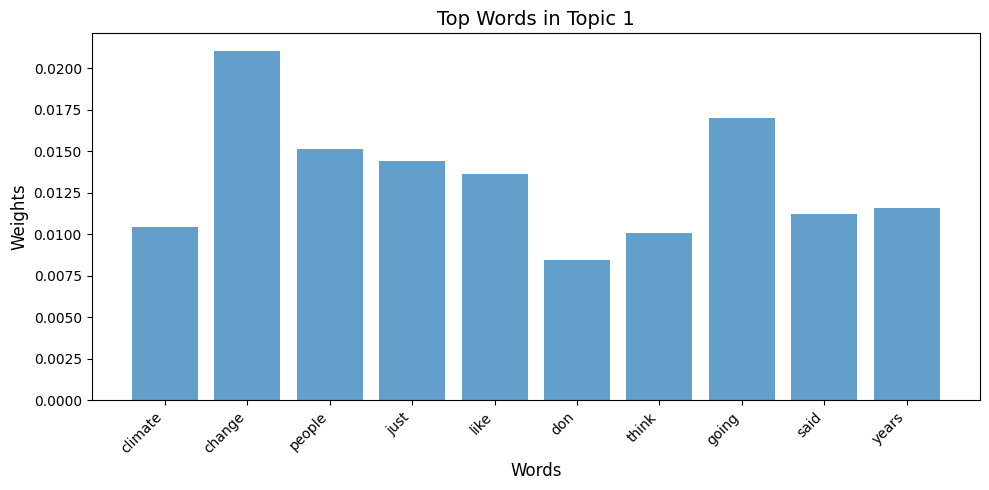

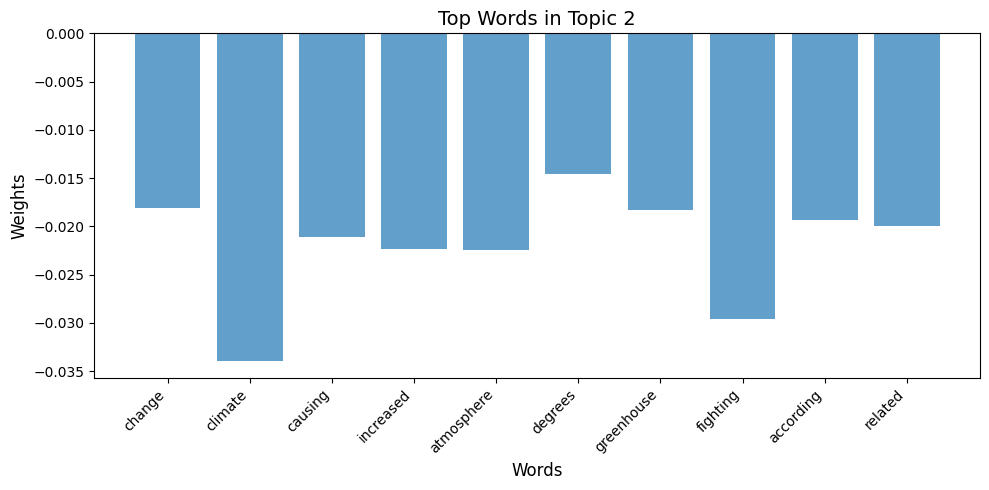

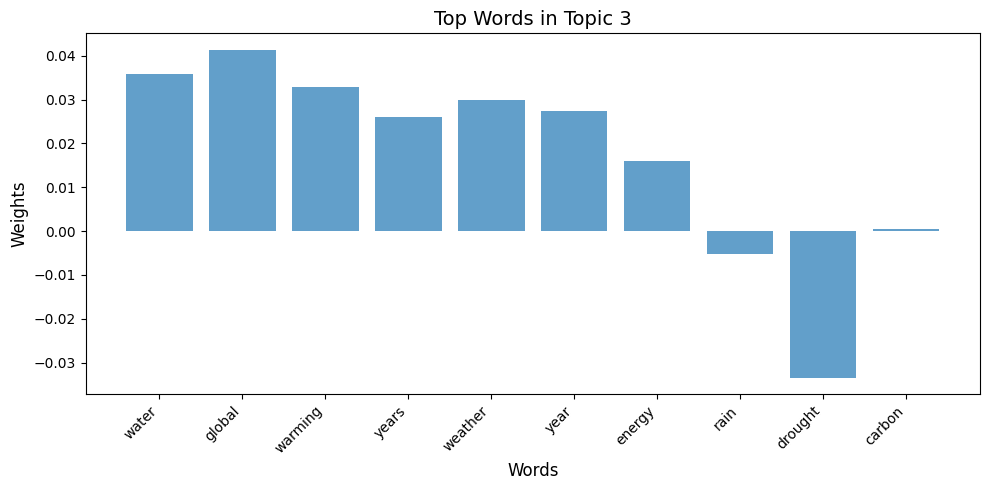

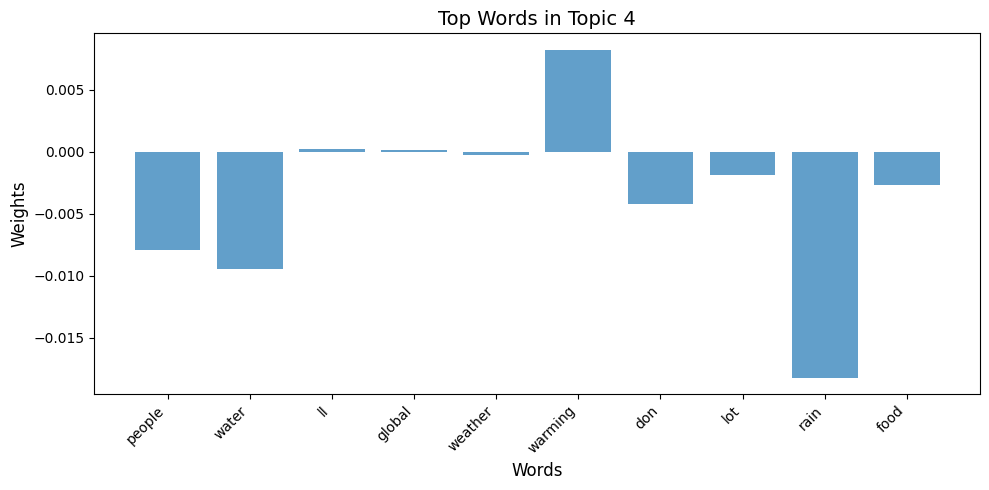

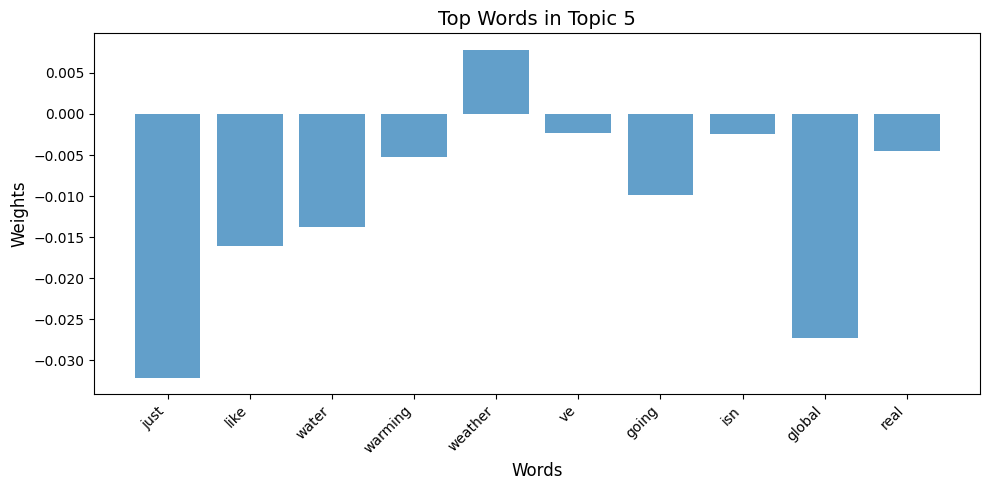

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the LSA topics using a bar chart for each topic
for i, topic in enumerate(topics_df.columns):
    plt.figure(figsize=(10, 5))
    words = topics_df[topic].values
    weights = lsa_model.components_[i][:len(words)]  # Corresponding weights for top words

    # Plot bar chart for the current topic
    plt.bar(words, weights[:len(words)], alpha=0.7)
    plt.title(f"Top Words in {topic}", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Weights", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


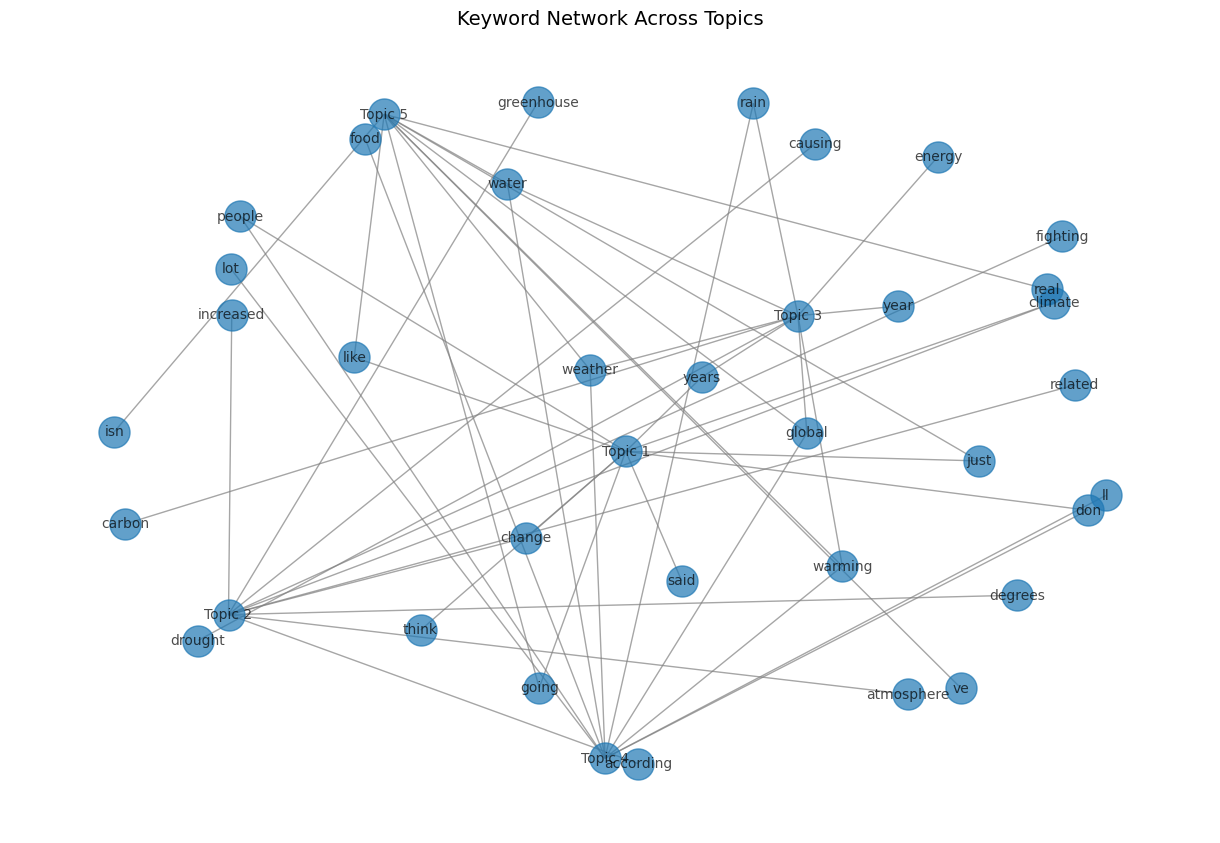

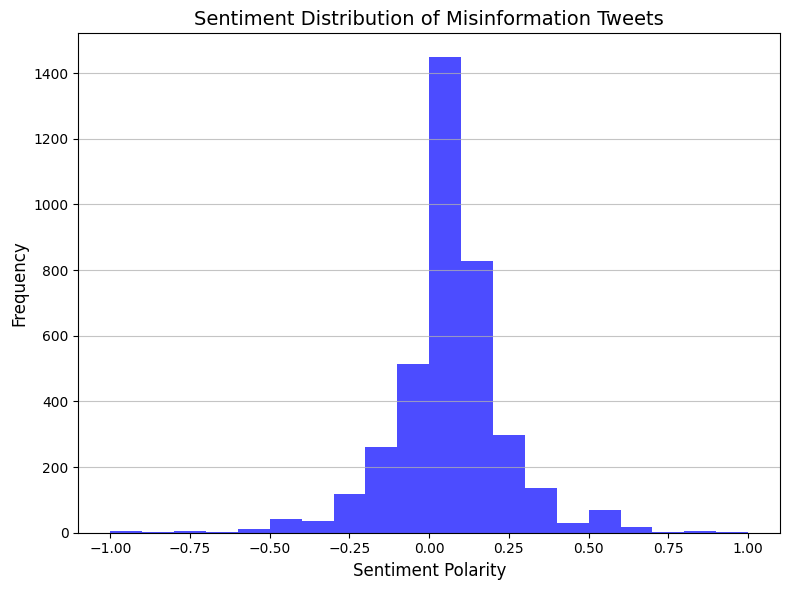

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from wordcloud import WordCloud

# **3. Keyword Network Visualization**
# Create a graph of keywords and their weights for each topic
G = nx.Graph()
for i, topic in enumerate(topics_df.columns):
    for word, weight in zip(topics_df[topic], lsa_model.components_[i][:len(topics_df[topic])]):
        G.add_edge(topic, word, weight=weight)

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network Across Topics", fontsize=14)
plt.show()

# **4. Sentiment Analysis**
from textblob import TextBlob

# Calculate sentiment polarity for each misinformation tweet
misinfo_tweets['sentiment'] = misinfo_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(misinfo_tweets['sentiment'], bins=20, color='blue', alpha=0.7)
plt.title("Sentiment Distribution of Misinformation Tweets", fontsize=14)
plt.xlabel("Sentiment Polarity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


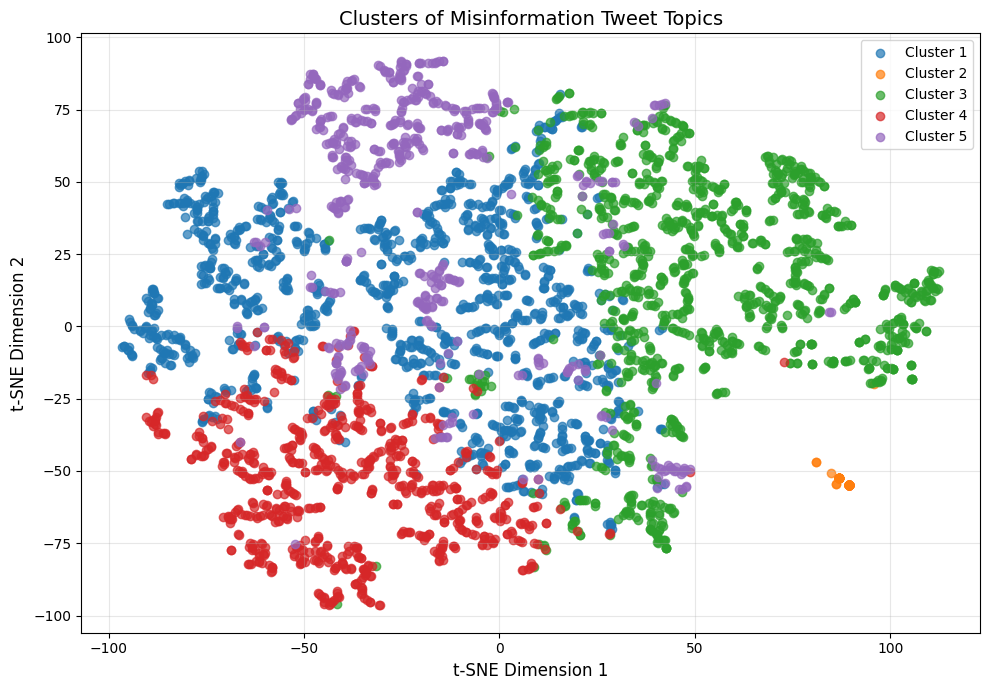

NameError: name 'tools' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Step 1: Clustering using KMeans
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(lsa_matrix)

# Add cluster labels to the original dataset
misinfo_tweets['cluster'] = clusters

# Step 2: Dimensionality reduction for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, learning_rate=200)
tsne_matrix = tsne.fit_transform(lsa_matrix)

# Step 3: Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    cluster_points = tsne_matrix[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster+1}", alpha=0.7
    )

plt.title("Clusters of Misinformation Tweet Topics", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Share the clustered tweets
tools.display_dataframe_to_user(name="Misinformation Tweet Clusters", dataframe=misinfo_tweets)


In [ ]:
# Extend vocabulary to include topics

vocabulary = vocab_idx
extended_vocabulary = list(vocabulary) + list(topics_df.columns)

# Map embeddings for the extended vocabulary
def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        if word in pre_trained_embeddings:
            embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
        else:
            # Assign random embeddings for missing words (e.g., topics)
            embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)
    return embedding_matrix

# Generate embeddings for the extended vocabulary
mapped_pretrained_embeddings = embedding_mapping_fasttext(
    vocabulary=extended_vocabulary,
    pre_trained_embeddings=ft
)

# Reduce embeddings to 2D
embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)
embedding_matrix = embedding_tensor.numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Map reduced embeddings to all nodes (including topics)
pos = {word: reduced_embeddings[idx] for idx, word in enumerate(extended_vocabulary)}

# Plot the network
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network with FastText Embedding-based Layout", fontsize=14)
plt.show()


In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # or PCA/UMAP
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Load your model & tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()

print("Model and tokenizer loaded successfully from:", model_path)

def get_embedding(text, model, tokenizer, device):
    """
    Returns the CLS embedding (or optionally the mean pooling)
    from the last hidden layer of the model.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs, output_hidden_states=True)
        # The last hidden state is output.hidden_states[-1]
        last_hidden_state = output.hidden_states[-1]  # shape: (batch_size, seq_len, hidden_size)
        # Let's use the [CLS] token embedding by default
        cls_embedding = last_hidden_state[:, 0, :].squeeze(0)
    return cls_embedding.cpu().numpy()

topics = topics_df.columns.tolist()

node_embeddings = {}
all_nodes = []

# 3a. Collect topic embeddings
for topic in topics:
    # Use the topic name itself as text, or a short representative phrase if you have one
    embedding = get_embedding(topic, bert_uncased_finetuned, bert_tokenizer, device)
    node_embeddings[topic] = embedding
    all_nodes.append(topic)

# 3b. Collect keyword embeddings
for topic in topics:
    for keyword in topics_df[topic]:
        keyword_str = keyword.strip()
        if keyword_str not in node_embeddings:  # Avoid duplicate embeddings
            embedding = get_embedding(keyword_str, bert_uncased_finetuned, bert_tokenizer, device)
            node_embeddings[keyword_str] = embedding
            all_nodes.append(keyword_str)

X = np.array([node_embeddings[node] for node in all_nodes])

# 4. Apply t-SNE to get 2D vectors
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_2d = tsne.fit_transform(X)

# We'll store the 2D coords in a dictionary keyed by node
pos_dict = {}
for node, (x, y) in zip(all_nodes, X_2d):
    pos_dict[node] = (x, y)

G = nx.Graph()

# Example: for each topic i, we take each word in topics_df[topic_i]
# and link them with an edge whose weight is lsa_model.components_[i][j]
# (assuming j indexes the same keyword in that row)
for i, topic in enumerate(topics):
    # i-th row in lsa_model.components_ corresponds to weights for topic i
    # We'll match each keyword and weight by index
    for keyword_index, keyword in enumerate(topics_df[topic]):
        weight = lsa_model.components_[i][keyword_index]
        # Add an edge between the topic name and the keyword
        G.add_edge(topic, keyword, weight=weight)

plt.figure(figsize=(14, 10))

# 6a. Draw the graph using our pos_dict as node positions
nx.draw(
    G, 
    pos_dict,
    with_labels=True,
    node_size=500,
    font_size=10,
    edge_color="gray",
    alpha=0.7
)

plt.title("Topic–Keyword Network (positioned by Transformer Embeddings)", fontsize=14)
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Step 1: Prepare the embeddings
embedding_matrix = embeddings.cpu().detach().numpy().reshape(embeddings.shape[0], -1)

# Step 2: Dimensionality Reduction using t-SNE (or PCA as an alternative)
# t-SNE
#tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
#reduced_embeddings = tsne.fit_transform(embedding_matrix)

# PCA (if you want a faster alternative)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Step 3: Assign colors based on topics
# Assume `topics` is a list where each entry corresponds to the topic of a document
# Example: topics = ["topic1", "topic2", ...]
topic_labels = topics_df.columns  # Get topic labels from your DataFrame
topic_indices = np.argmax(lsa_model.transform(embedding_matrix), axis=1)  # Assign topics

# Generate a color map
unique_topics = np.unique(topic_labels)
color_map = {topic: plt.cm.tab10(i / len(unique_topics)) for i, topic in enumerate(unique_topics)}

# Step 4: Plot the embeddings
plt.figure(figsize=(10, 8))
for topic in unique_topics:
    indices = np.where(topic_indices == topic_labels.index(topic))[0]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=topic,
        alpha=0.7,
        edgecolors="k",
    )

plt.title("2D Visualization of Embeddings by Topic")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Topics", loc="best")
plt.show()
